# Error Analysis: Object Categories

Analyze **Category-wise** model performance

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from utils import read_json, to_prob_dist, sort_dict

In [2]:
test = read_json('../dataset/color/test.json')
obj2cat = read_json('./obj2cat.json')

SCORE = {'bert': 66.87, 'clip': 79.96}

In [47]:
MODEL = 'clip'

df = pd.read_csv(f'../temp/{MODEL}_col.csv')

df['pred'] = df['pred'].apply(lambda x: str(x))
df['correct'] = df.apply(lambda x: x['pred'] in x['true'], axis=1)
df['object'] = list(test)
df['category'] = df['object'].apply(lambda o: obj2cat[o])

# df.groupby(['category'])['correct'].mean().to_dict()

In [53]:
bert = {'animal': 0.5841584158415841,
        'animal body': 0.6575682382133995,
        'bathroom': 0.7333333333333333,
        'clothing': 0.7,
        'construction': 0.7317073170731707,
        'electronics': 0.6983372921615202,
        'food': 0.5640138408304498,
        'furniture': 0.7395833333333334,
        'human body': 0.5595238095238095,
        'kitchenware': 0.6438095238095238,
        'miscellaneous': 0.6690391459074733,
        'nature': 0.6134259259259259,
        'person': 0.7275641025641025,
        'sports equipment': 0.6669557675628794,
        'street': 0.6429268292682927,
        'utility items': 0.6496815286624203,
        'vehicle': 0.7056179775280899}

clip = {'animal': 0.7871287128712872,
        'animal body': 0.7741935483870968,
        'bathroom': 0.8466666666666667,
        'clothing': 0.8546666666666667,
        'construction': 0.8292682926829268,
        'electronics': 0.7553444180522565,
        'food': 0.8391003460207612,
        'furniture': 0.8502604166666666,
        'human body': 0.7023809523809523,
        'kitchenware': 0.8,
        'miscellaneous': 0.7544483985765125,
        'nature': 0.7916666666666666,
        'person': 0.7596153846153846,
        'sports equipment': 0.7935819601040763,
        'street': 0.8009756097560976,
        'utility items': 0.7197452229299363,
        'vehicle': 0.8033707865168539}

In [54]:
def _scale(arr, by=100):
    return [_ * by for _ in arr]

labels = list(bert)
bert = _scale(list(bert.values()))
clip = _scale(list(clip.values()))

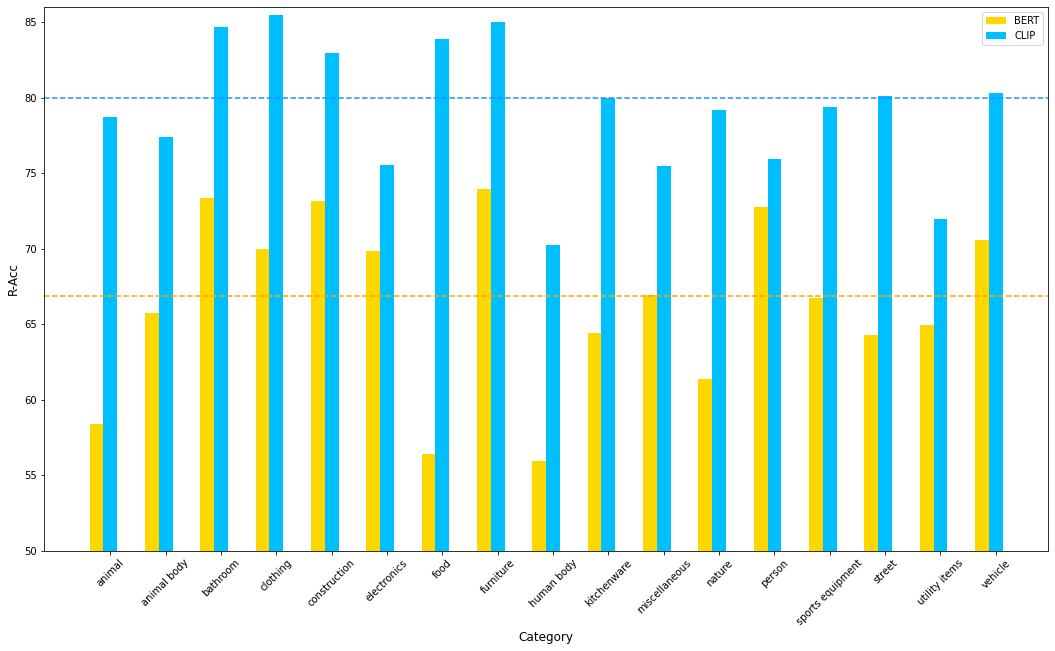

In [77]:
barWidth = 0.25
fig = plt.subplots(figsize=(18, 10))

br1 = list(range(len(bert)))
br2 = [x + barWidth for x in br1]

plt.bar(br1, bert, color='gold', width=barWidth, label='BERT')
plt.bar(br2, clip, color='deepskyblue', width=barWidth, label='CLIP')

plt.axhline(y=SCORE['bert'], linestyle='--', color='orange')
plt.axhline(y=SCORE['clip'], linestyle='--', color='dodgerblue')

plt.xlabel('Category', fontsize=12)
plt.ylabel('R-Acc', fontsize=12)

plt.xticks([r + barWidth for r in range(len(bert))], labels, rotation=45)
plt.ylim([50, 86])

plt.legend()
# plt.show()
plt.savefig('./category_bert_clip.pdf', bbox_inches='tight')


<br>

## Additional Stats


#### Label Cardinality

In [39]:
df['cardinality'] = df['true'].apply(lambda t: len(t.split(',')))
df.groupby(['category'])['cardinality'].mean()

category
animal              2.247525
animal body         2.223325
bathroom            1.991111
clothing            2.812000
construction        2.676829
electronics         2.247031
food                1.986159
furniture           2.417969
human body          2.154762
kitchenware         2.085714
miscellaneous       2.718861
nature              2.156250
person              2.423077
sports equipment    2.464007
street              2.383415
utility items       2.605096
vehicle             2.698876
Name: cardinality, dtype: float64

#### Object Frequency

In [22]:
freq = dict(Counter(obj2cat.values()))
freq = to_prob_dist(freq)
freq = {o: int(f * 100) for o, f in freq.items()}
freq = sort_dict(freq, by='v', reverse=True)
freq

{'sports equipment': 12,
 'street': 11,
 'vehicle': 9,
 'nature': 9,
 'clothing': 8,
 'furniture': 8,
 'food': 6,
 'kitchenware': 5,
 'bathroom': 5,
 'electronics': 4,
 'animal body': 4,
 'construction': 3,
 'person': 3,
 'miscellaneous': 2,
 'animal': 2,
 'human body': 1,
 'utility items': 1}

<br>

## Color Distribution

In [71]:
from color.constants import COLOR_SET

def _stacked_bar_plot(_df: pd.DataFrame, color_set=COLOR_SET, save=None):
    # replace color codes
    def _map(c):
        c = c.replace('white', 'whitesmoke')
        c = c.replace('blue', 'deepskyblue')
        # c = c.replace('green', 'limegreen')
        c = c.replace('gray', 'silver')
        c = c.replace('brown', 'saddlebrown')
        c = c.replace('pink', 'deeppink')
        c = c.replace('purple', 'blueviolet')
        return c

    color_set = [_map(color) for color in color_set]

    # plot
    _df.plot.bar(x='category', stacked=True, color=color_set,
                 edgecolor="lightgray", figsize=(20, 12), rot=90)
    plt.xticks(fontsize=16)
    plt.legend(loc=(1.02, 0))
    if save:
        plt.savefig(save, bbox_inches='tight')
    else:
        plt.show()

In [23]:
cat2colors = dict.fromkeys(list(freq))

for cat in cat2colors:
    group = df[df['category'] == cat]['true'].tolist()
    true = []
    for _ in group:
        _ = _.split(',')
        _ = [COLOR_SET[int(i)] for i in _]
        true += _
    true = to_prob_dist(dict(Counter(true)))

    cat2colors[cat] = true

In [69]:
_df = []
for cat, colors in cat2colors.items():
    colors['category'] = f'{cat} ({freq[cat]}%)'
    _df += [colors]

_df = pd.DataFrame(_df).fillna(0)
_df = _df[['category'] + COLOR_SET]

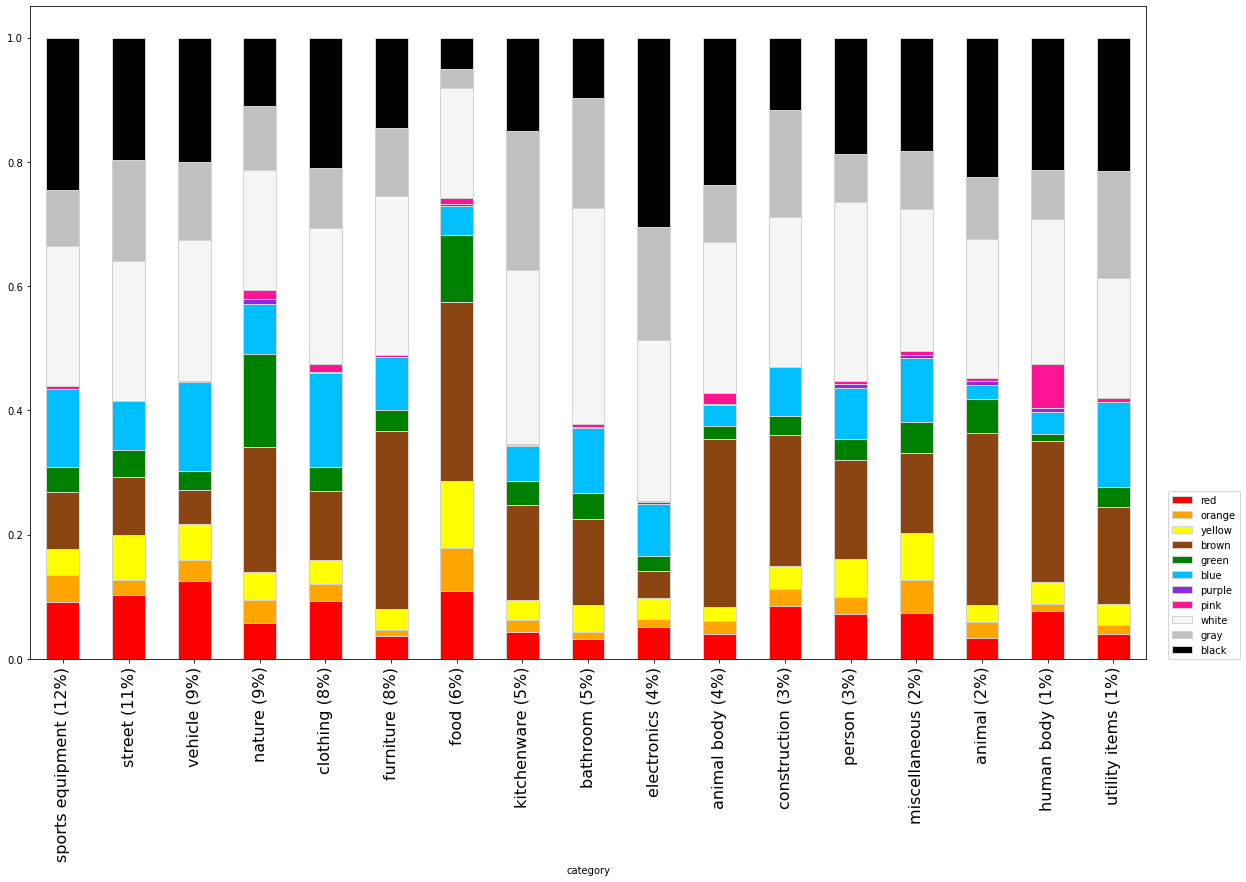

In [74]:
_stacked_bar_plot(_df, save='./category_colors.pdf')

## Report stats in Dataset (sec. 3)?